# 4. Imaging cytometry
FACED imaging cytometry based biophysical features: MCF7 Cell Cycle

In [2]:
import pyVIA.core as via
import pandas as pd
import numpy as np
import scanpy as sc     
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load data
the feature matrix and known phase labels. M1 denotes G1 phase, M2 denotes S phase and M3 denotes M/G2 phase

In [27]:
df=pd.read_csv('/home/shobi/Trajectory/Datasets/FACED/mcf7_38features.csv')
df = df.drop('Unnamed: 0', 1)

true_label = pd.read_csv('/home/shobi/Trajectory/Datasets/FACED/mcf7_phases.csv')
true_label = list(true_label['phase'].values.flatten())
print('There are ', len(true_label), 'MCF7 cells and ', df.shape[1], 'features')

There are  2036 MCF7 cells and  38 features


In [28]:
ad = sc.AnnData(df)
ad.var_names = df.columns
#normalize features
sc.pp.scale(ad)

sc.tl.pca(ad, svd_solver='arpack')
# Weight the top features (ranked by Mutual Information and Random Forest Classifier)
X_in = ad.X  
df_X = pd.DataFrame(X_in)
df_X.columns = df.columns

df_X['Area'] = df_X['Area'] * 3
df_X['Dry Mass'] = df_X['Dry Mass'] * 3
df_X['Volume'] = df_X['Volume'] * 20

X_in = df_X.values
ad = sc.AnnData(df_X)
#apply PCA
sc.tl.pca(ad, svd_solver='arpack')
ad.var_names = df_X.columns

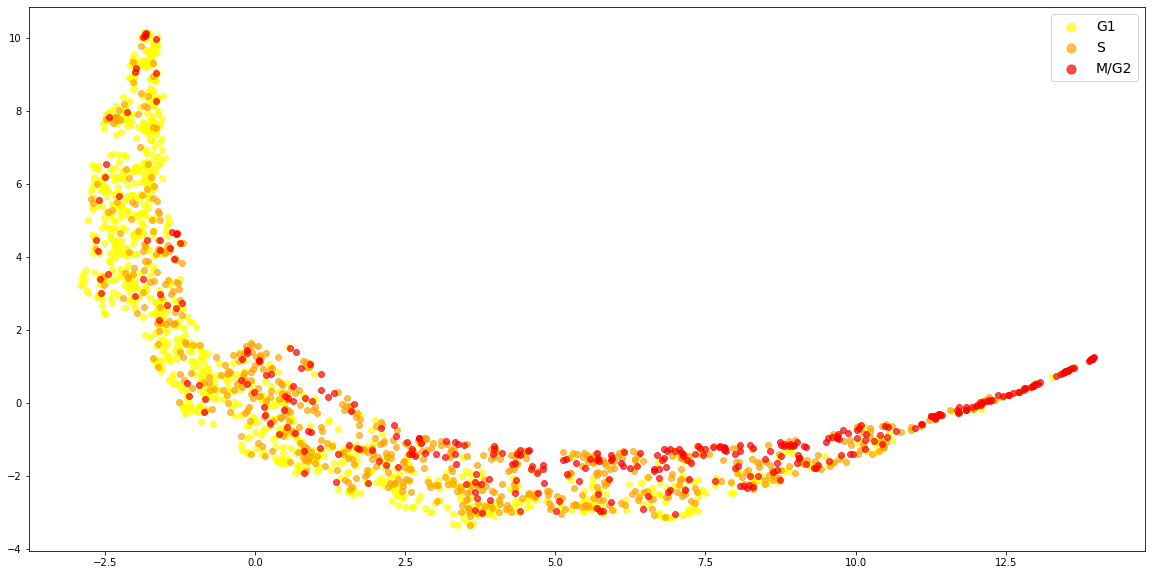

In [29]:
f, ax = plt.subplots(figsize = [20,10])

embedding = umap.UMAP().fit_transform(ad.obsm['X_pca'][:, 0:20])
#phate_op = phate.PHATE()
# embedding = phate_op.fit_transform(X_in)



cell_dict = {'T1_M1': 'yellow', 'T2_M1': 'yellowgreen', 'T1_M2': 'orange', 'T2_M2': 'darkgreen', 'T1_M3': 'red',
             'T2_M3': 'blue'}
cell_phase_dict = {'T1_M1': 'G1', 'T2_M1': 'G1', 'T1_M2': 'S', 'T2_M2': 'S', 'T1_M3': 'M/G2', 'T2_M3': 'M/G2'}

for key in list(set(true_label)):  # ['T1_M1', 'T2_M1','T1_M2', 'T2_M2','T1_M3', 'T2_M3']:
    loc = np.where(np.asarray(true_label) == key)[0]
    ax.scatter(embedding[loc, 0], embedding[loc, 1], c=cell_dict[key], alpha=.7, label=cell_phase_dict[key])
plt.legend(markerscale=1.5, fontsize=14)
plt.show()
true_label = [cell_phase_dict[i] for i in true_label]

### Run VIA

2022-03-11 13:36:46.306400	Running VIA over input data of 2036 (samples) x 38 (features)


2022-03-11 13:36:46.676858	Global pruning of weighted knn graph


2022-03-11 13:36:47.039706	Finished global pruning. Kept 65.13 of edges. 
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 


size neighbor array in low-KNN in pca-space for visualization (2036, 4)
2022-03-11 13:36:47.876505	Commencing community detection
2022-03-11 13:36:47.959415	Finished running Leiden algorithm. Found 16 clusters.
2022-03-11 13:36:47.960391	Merging 2 very small clusters (<10)
2022-03-11 13:36:47.961202	Finished detecting communities. Found 14 communities
2022-03-11 13:36:47.961433	Making cluster graph. Global cluster graph pruning level: 0.15
2022-03-11 13:36:47.966617	Graph has 1 connected components before pruning
2022-03-11 13:36:47.968050	0.0% links trimmed from local pruning relative to start
2022-03-11 13:36:47.968087	47.1% links trimmed from global pruning relative to start
new root is 0  with degree 15.57 G1
new root is 4  with degree 14.75 G1
new root is 10  with degree 9.21 G1
2022-03-11 13:36:47.986280	Computing lazy-teleporting expected hitting times


ended all multiprocesses, will retrieve and reshape
2022-03-11 13:36:48.449853	Identifying terminal clusters corresponding to unique lineages...
2022-03-11 13:36:48.450017	Closeness:[0, 2, 10, 11, 12, 13]
2022-03-11 13:36:48.450059	Betweenness:[7, 9, 10, 11, 12, 13]
2022-03-11 13:36:48.450089	Out Degree:[0, 2, 3, 4, 6, 7, 12, 13]
2022-03-11 13:36:48.451824	Terminal clusters corresponding to unique lineages in this component are [2, 7, 12, 13] 


From root 10  to Terminal state 2 is found 500  times.


From root 10  to Terminal state 7 is found 465  times.


From root 10  to Terminal state 12 is found 500  times.


From root 10  to Terminal state 13 is found 500  times.
2022-03-11 13:36:48.987922	Terminal clusters corresponding to unique lineages are [2, 7, 12, 13] 
2022-03-11 13:36:48.988060	Begin projection of pseudotime and lineage likelihood


2022-03-11 13:36:49.268003	Graph has 1 connected components before pruning
2022-03-11 13:36:49.270556	Graph has 1 connected components after reconnecting
2022-03-11 13:36:49.270835	27.8% links trimmed from local pruning relative to start
2022-03-11 13:36:49.270883	52.8% links trimmed from global pruning relative to start


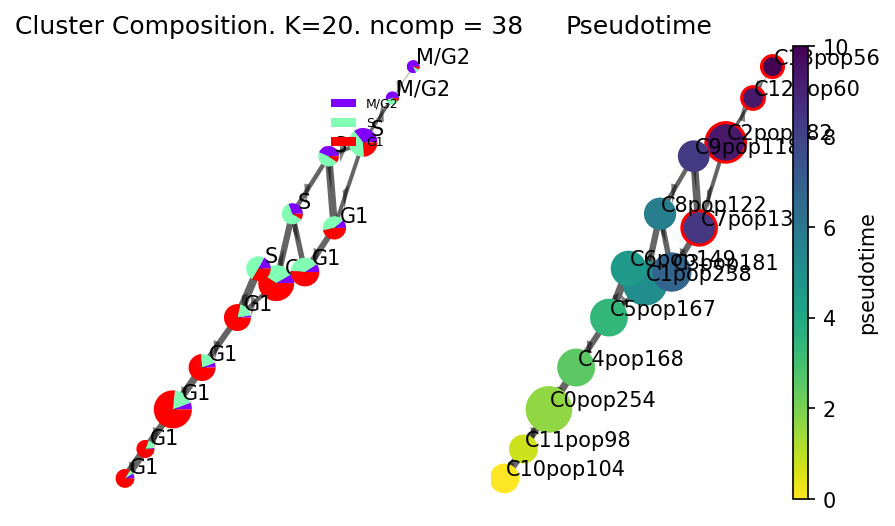

time elapsed 3.1 seconds


In [30]:
 
knn=20
jac_std_global = 0.5
random_seed = 1
root_user = ['G1']
v0 = via.VIA(X_in, true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
         too_big_factor=0.3, root_user=root_user, dataset='group', random_seed=random_seed,
          is_coarse=True, preserve_disconnected=True, preserve_disconnected_after_pruning=True,
         pseudotime_threshold_TS=40) 
v0.run_VIA()

It is optional to run a finer grained version of VIA (v1) and all visualization and gene trends can be plotted with a single iteration of via (v0) too without v1. It depends on your data and whether you find it is useful to run a very finegrained version after collecting the Terminal States on a more coarse grained iteration.

2022-03-11 13:36:59.543699	Running VIA over input data of 2036 (samples) x 38 (features)


2022-03-11 13:36:59.869201	Global pruning of weighted knn graph


2022-03-11 13:37:00.204121	Finished global pruning. Kept 65.13 of edges. 
2022-03-11 13:37:00.204219	Commencing community detection
2022-03-11 13:37:00.289480	Finished running Leiden algorithm. Found 16 clusters.
2022-03-11 13:37:00.290056	Found 11 clusters that are too big
inside handle too big
2022-03-11 13:37:00.290125	Cluster 1 contains 237>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.321996	Cluster 0 contains 254>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.356364	Cluster 5 contains 167>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.376941	Cluster 3 contains 181>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.399022	Cluster 4 contains 168>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.419146	Cluster 7 contains 139>102 samples and is too big


inside handle too big
2022-03-11 13:37:00.435470	Cluster 10 contains 104>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.456593	Cluster 2 contains 182>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.478772	Cluster 8 contains 122>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.492647	Cluster 6 contains 148>102 samples and is too big
inside handle too big
2022-03-11 13:37:00.509913	Cluster 9 contains 118>102 samples and is too big
2022-03-11 13:37:00.523021	Merging 2 very small clusters (<10)
2022-03-11 13:37:00.523831	Finished detecting communities. Found 60 communities
2022-03-11 13:37:00.524069	Making cluster graph. Global cluster graph pruning level: 0.15
2022-03-11 13:37:00.555839	Graph has 1 connected components before pruning
2022-03-11 13:37:00.558576	0.0% links trimmed from local pruning relative to start
2022-03-11 13:37:00.558622	62.2% links trimmed from global pruning relative to start
new root is 0  with degree 1

ended all multiprocesses, will retrieve and reshape
the sub terminal cluster that best captures the super terminal 2 is 43
the sub terminal cluster that best captures the super terminal 7 is 33
the sub terminal cluster that best captures the super terminal 12 is 1
the sub terminal cluster that best captures the super terminal 13 is 2
2022-03-11 13:37:02.453416	Terminal clusters corresponding to unique lineages in this component are [43, 33, 1, 2] 


From root 35  to Terminal state 43 is found 226  times.


From root 35  to Terminal state 33 is found 245  times.


From root 35  to Terminal state 1 is found 5  times.


From root 35  to Terminal state 2 is found 5  times.
2022-03-11 13:37:04.677000	Terminal clusters corresponding to unique lineages are [43, 33, 1, 2] 
2022-03-11 13:37:04.677160	Begin projection of pseudotime and lineage likelihood


2022-03-11 13:37:04.966417	Graph has 1 connected components before pruning
2022-03-11 13:37:04.973804	Graph has 1 connected components after reconnecting
2022-03-11 13:37:04.973981	60.6% links trimmed from local pruning relative to start
2022-03-11 13:37:04.974019	74.5% links trimmed from global pruning relative to start


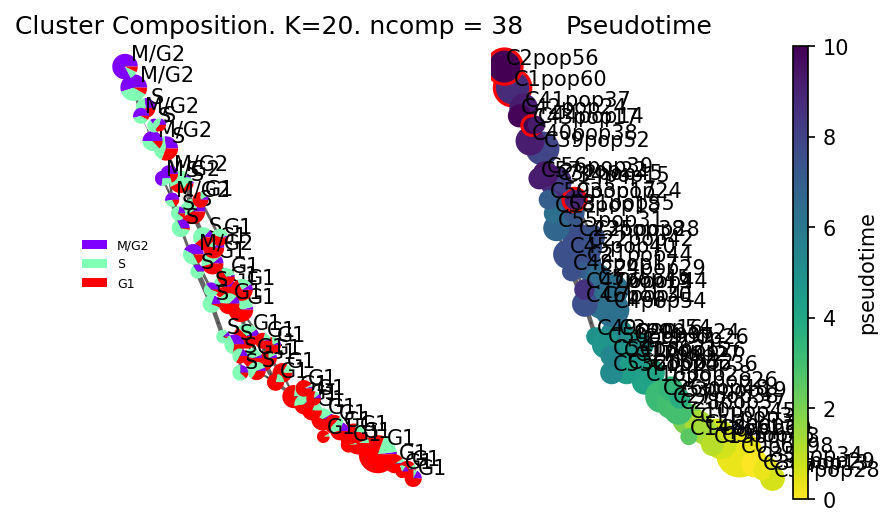

time elapsed 6.9 seconds


In [31]:
tsi_list = via.get_loc_terminal_states(v0, X_in)

v1 = via.VIA(X_in, true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
         too_big_factor=0.05, super_cluster_labels=v0.labels, super_node_degree_list=v0.node_degree_list,
         super_terminal_cells=tsi_list, root_user=root_user, is_coarse=False,
         preserve_disconnected=True, dataset='faced',
         super_terminal_clusters=v0.terminal_clusters, random_seed=random_seed,
         full_neighbor_array=v0.full_neighbor_array, full_distance_array=v0.full_distance_array,
         ig_full_graph=v0.ig_full_graph,
         csr_array_locally_pruned=v0.csr_array_locally_pruned, pseudotime_threshold_TS=40)
v1.run_VIA()

### Visualize output

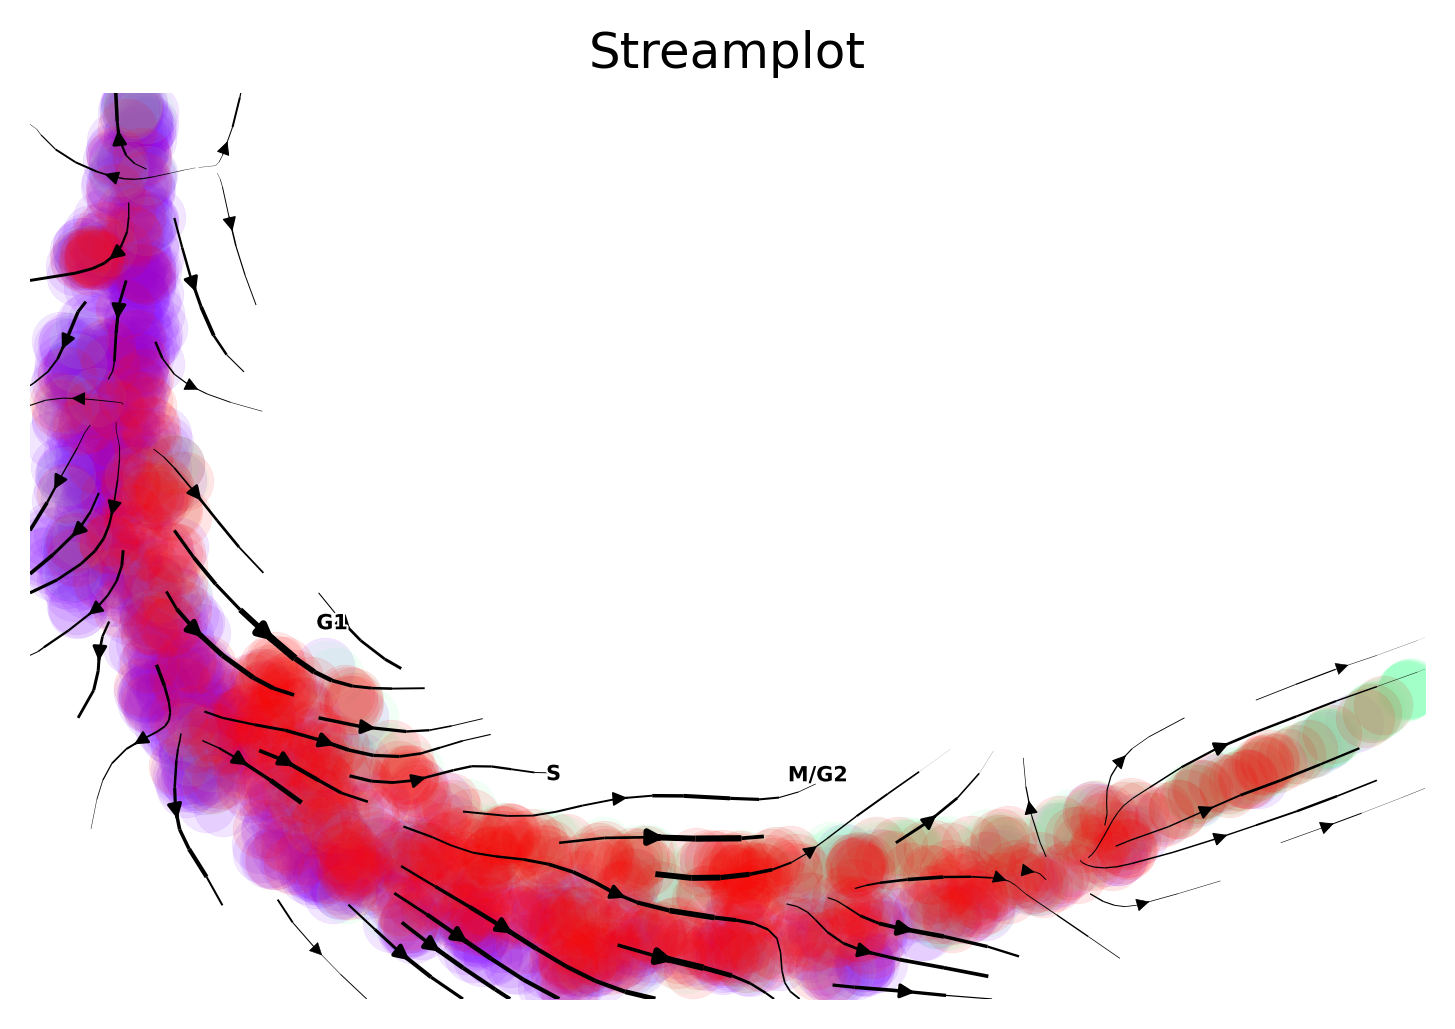

In [47]:
via.via_streamplot(via_coarse=v0,embedding=embedding, scatter_size=200, scatter_alpha=0.1, density_grid=.5, density_stream=1, smooth_transition=1) #you can choose to use either v1 or v0 as the input for the streamplot
plt.show()

dict of terminal state pairs, Super: sub:  {2: 43, 7: 33, 12: 1, 13: 2}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 2 is a super terminal with sub_terminal cluster 43
super cluster 7 is a super terminal with sub_terminal cluster 33
super cluster 12 is a super terminal with sub_terminal cluster 1
super cluster 13 is a super terminal with sub_terminal cluster 2


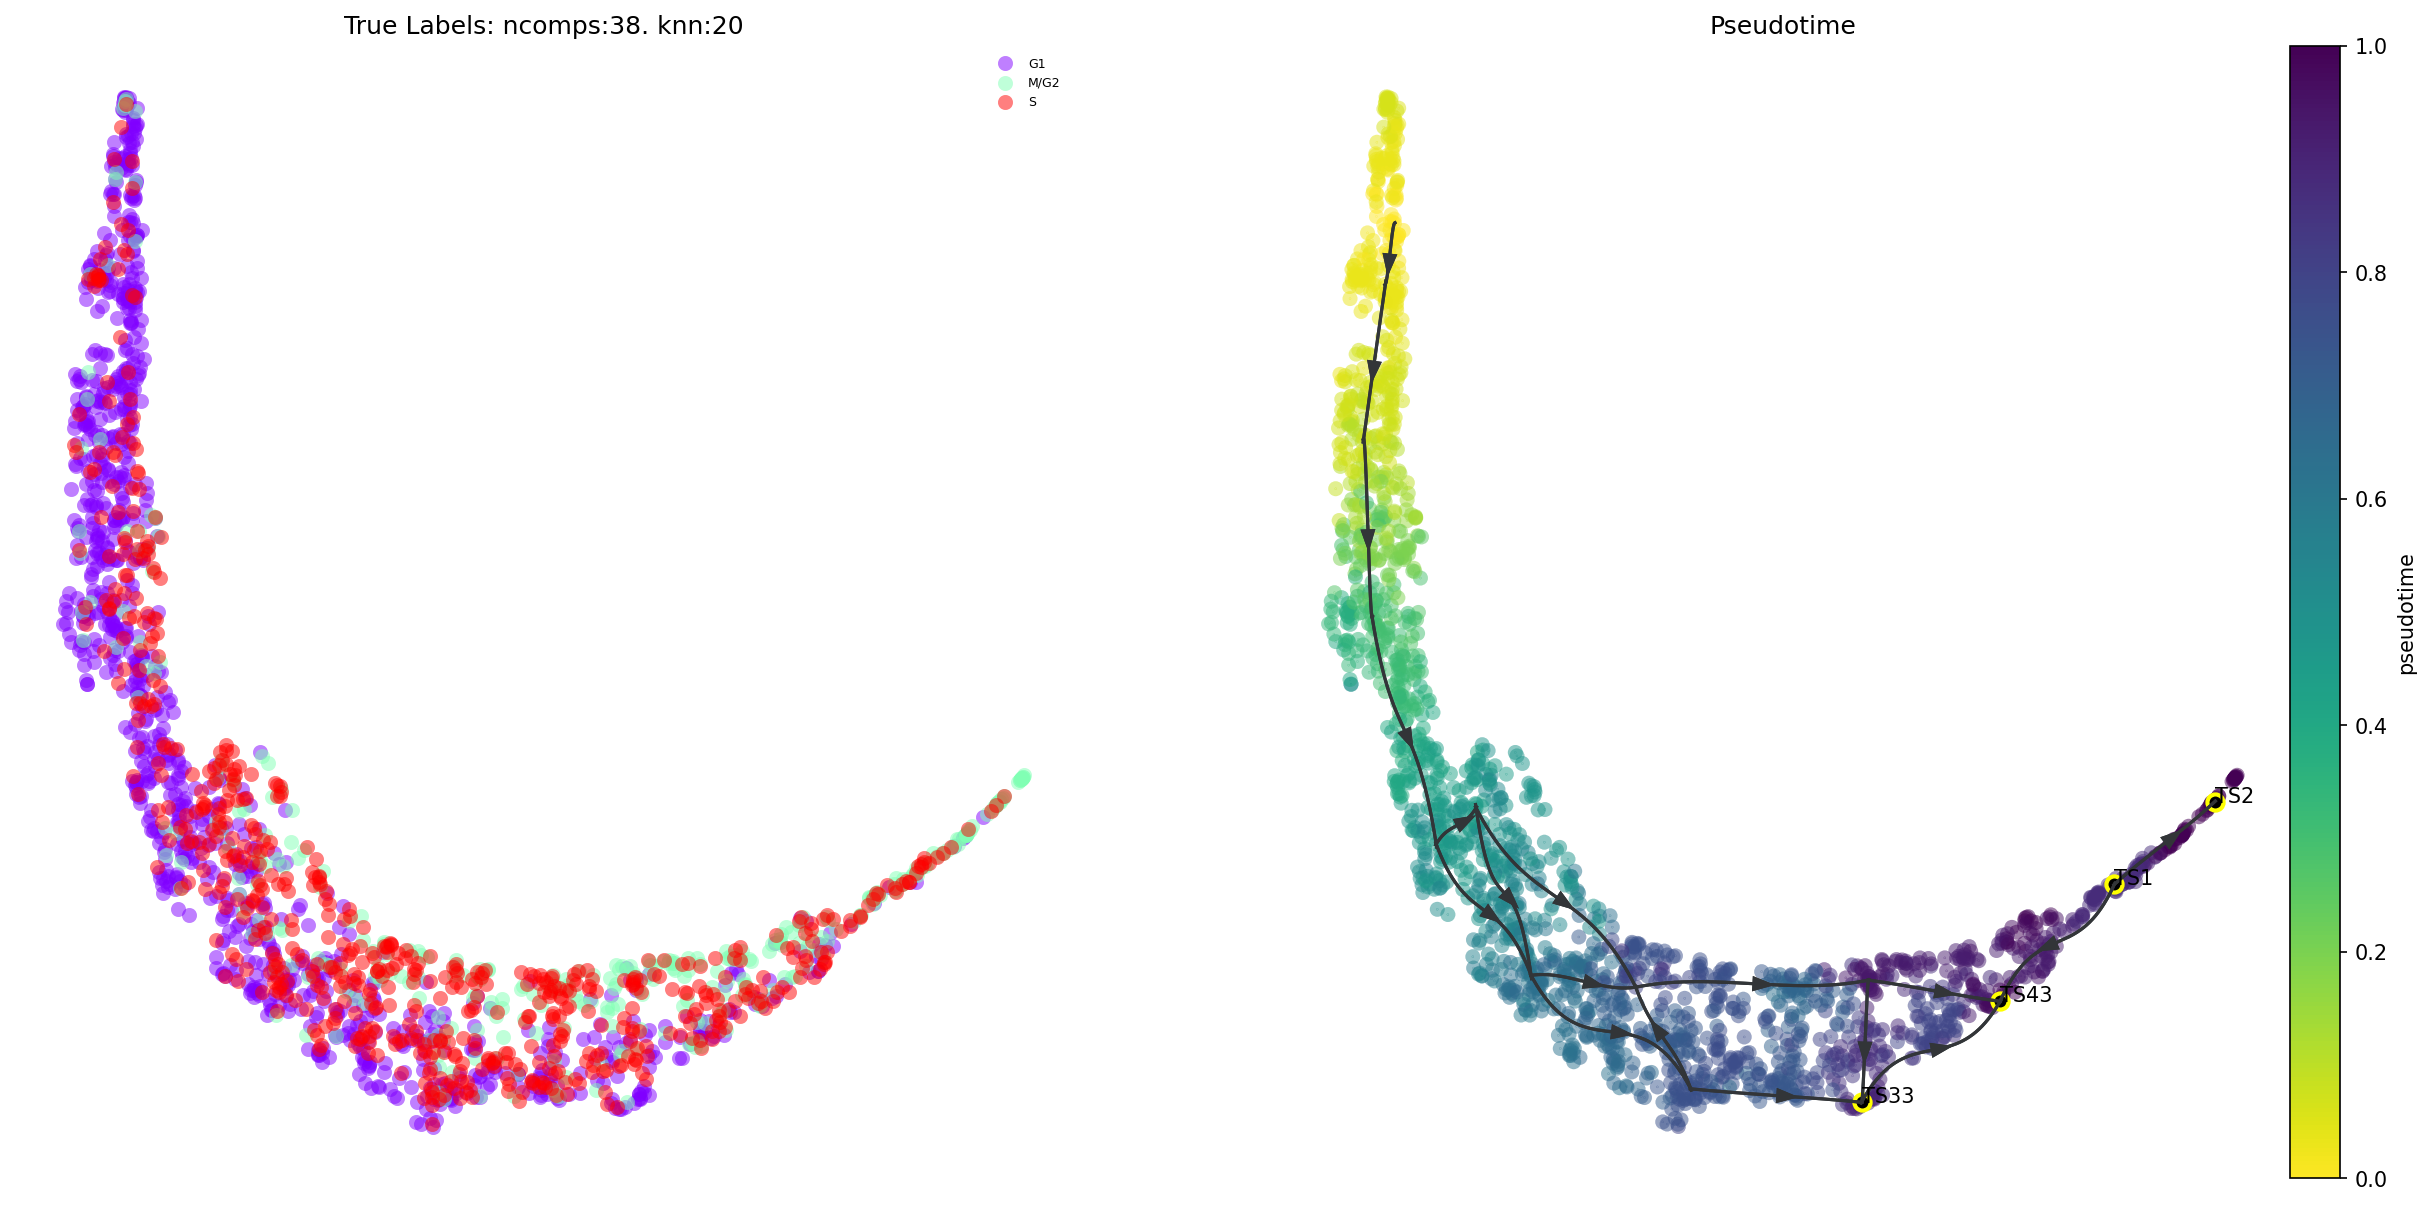

In [49]:
via.draw_trajectory_gams(via_coarse=v0, via_fine=v1, embedding=embedding)
plt.show()

### Physical Feature Dynamics

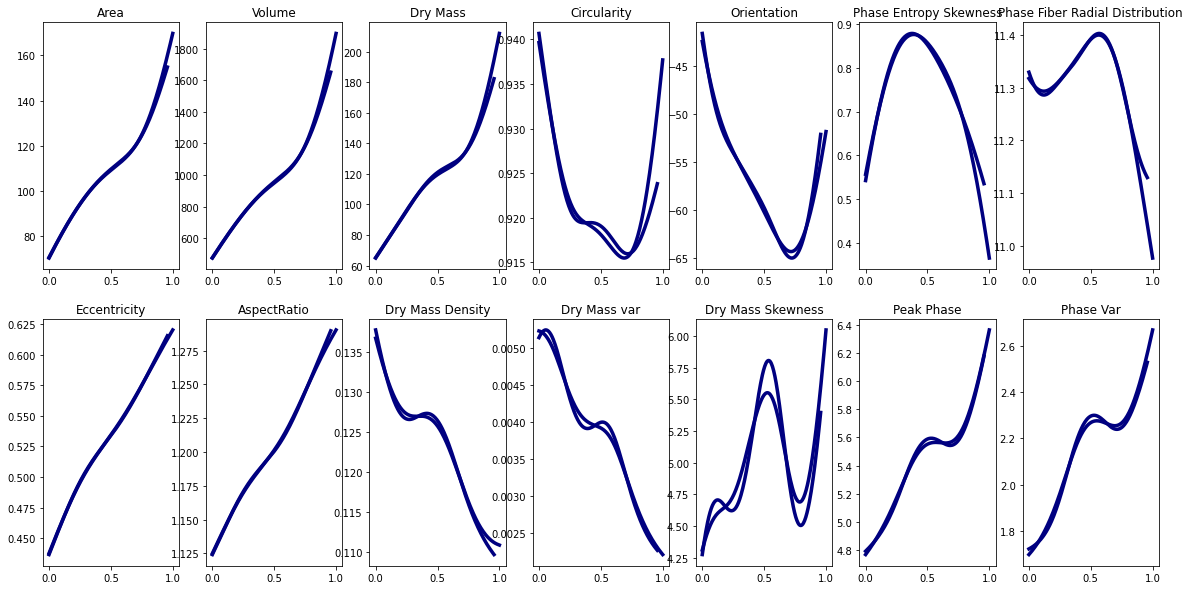

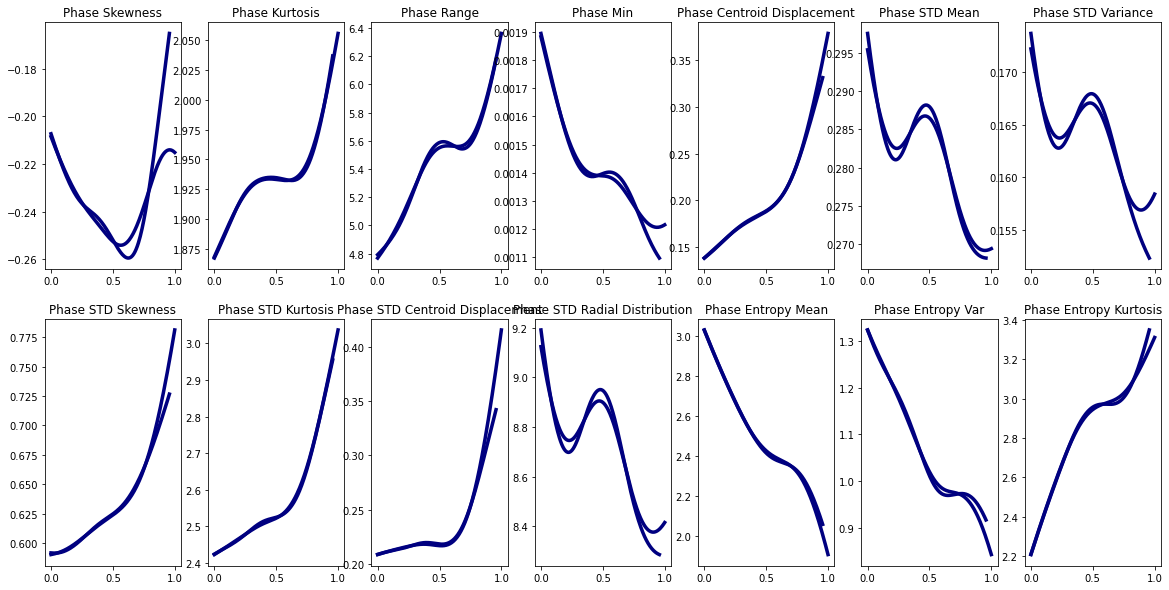

In [12]:
all_cols = ['Area', 'Volume', 'Dry Mass', 'Circularity', 'Orientation', 'Phase Entropy Skewness',
                'Phase Fiber Radial Distribution', 'Eccentricity', 'AspectRatio', 'Dry Mass Density', 'Dry Mass var',
                'Dry Mass Skewness', 'Peak Phase', 'Phase Var', 'Phase Skewness', 'Phase Kurtosis', 'Phase Range',
                'Phase Min', 'Phase Centroid Displacement', 'Phase STD Mean', 'Phase STD Variance',
                'Phase STD Skewness', 'Phase STD Kurtosis', 'Phase STD Centroid Displacement',
                'Phase STD Radial Distribution', 'Phase Entropy Mean', 'Phase Entropy Var', 'Phase Entropy Kurtosis',
                'Phase Entropy Centroid Displacement', 'Phase Entropy Radial Distribution',
                'Phase Fiber Centroid Displacement', 'Phase Fiber Pixel >Upper Percentile', 'Phase Fiber Pixel >Median',
                'Mean Phase Arrangement', 'Phase Arrangement Var', 'Phase Arrangement Skewness',
                'Phase Orientation Var', 'Phase Orientation Kurtosis']
plot_n = 7
fig, axs = plt.subplots(2, plot_n, figsize = [20,10])  # (2,10)
for enum_i, pheno_i in enumerate(all_cols[0:14]):  # [0:14]
    subset_ = df[pheno_i].values

    if enum_i >= plot_n:
        row = 1
        col = enum_i - plot_n
    else:
        row = 0
        col = enum_i
    ax = axs[row, col]
    v0.get_gene_expression_multi(ax=ax, gene_exp=subset_, title_gene=pheno_i)


fig2, axs2 = plt.subplots(2, plot_n,figsize = [20,10])
for enum_i, pheno_i in enumerate(all_cols[2*plot_n:2*plot_n+14]):
    subset_ = df[pheno_i].values

    if enum_i >= plot_n:
        row = 1
        col = enum_i - plot_n
    else:
        row = 0
        col = enum_i

    ax2 = axs2[row, col]
    v0.get_gene_expression_multi(ax=ax2, gene_exp=subset_, title_gene=pheno_i)

plt.show()